| **Chapter**                   | 6:  Modeling the control of infectious disease           |
| ----------------------------- |----------------------------------------------------------|
| **Computational Note**        | 6.3: Modeling the effect of different quarantine regimes |
| **Package prerequisites**     | None                                                     |

# Modeling the effect of different quarantine regimes

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib import rcParams

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

numpy     : 1.22.4
matplotlib: 3.5.2



In [3]:
S_0 = 1
I_0 = 0.0001
R_0 = 0

y_0 = (S_0, I_0, R_0)

R0 = 2.5
tau = 8
gamma = 1/tau
beta = R0 * gamma

In [4]:
def deriv(t, y, beta, gamma):
    S, I, R = y

    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I

    return dSdt, dIdt, dRdt

def deriv_with_quarantine(t, y, beta, gamma, chi, tau_q, t_q):
    S, I, R = y

    if t_q < t < t_q + tau_q:
        beta_eff = beta * chi
    else:
        beta_eff = beta

    dSdt = -beta_eff * S * I
    dIdt = beta_eff * S * I - gamma * I
    dRdt = gamma * I

    return dSdt, dIdt, dRdt

In [5]:
res = solve_ivp(fun=deriv, t_span = (0, 180), y0=y_0, args=(beta, gamma), max_step=0.3)

res_q = []

quarantine_lengths = (14, 21, 28, 35)
line_styles = ("dotted", "dashed", "dashdot", (0, (3, 5, 1, 5)))

chi = 0.3

for tau_q in quarantine_lengths:
    res_q.append(solve_ivp(fun=deriv_with_quarantine, t_span=(0, 180), y0=y_0, args=(beta, gamma, chi, tau_q, 35), max_step=0.3))

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_26549/2112098418.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


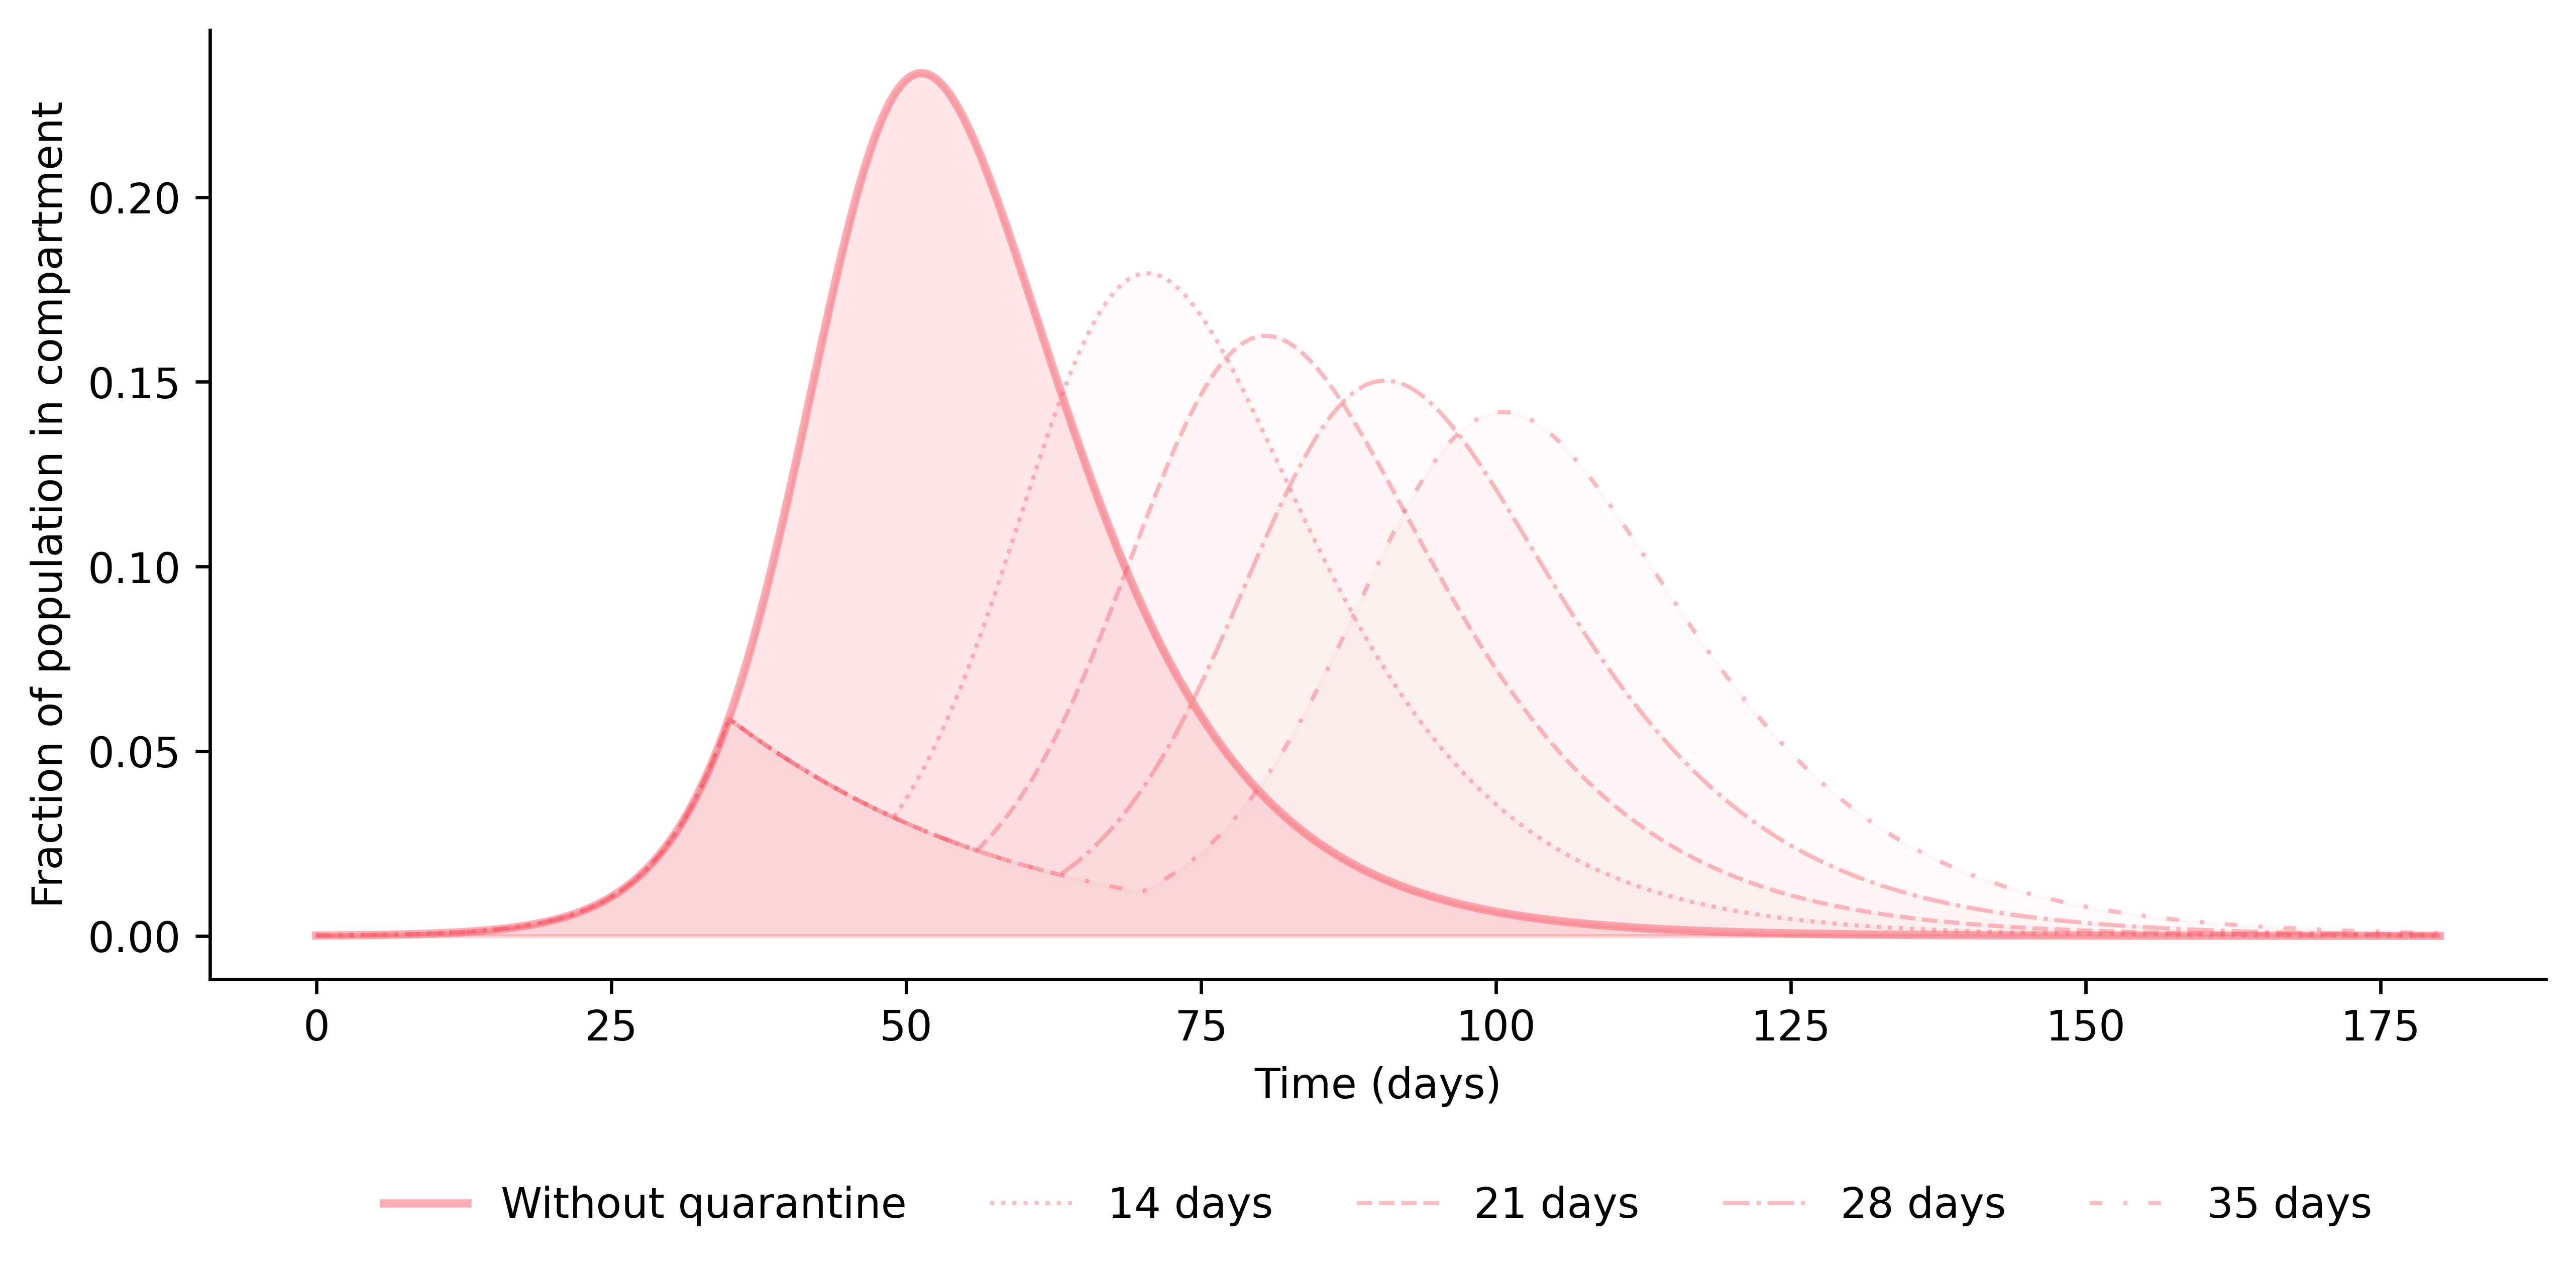

In [6]:
_, I, _ = res.y

fig = plt.figure(facecolor="w", figsize=(10, 5), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(res.t, I, color=COLORS["I"], alpha=0.5, lw=2, label="Without quarantine")
ax.fill_between(res.t, 0, I, color=COLORS["I"], alpha=0.15)

for idx, result in enumerate(res_q):
    ax.plot(result.t, result.y[1], color=COLORS["I"], alpha=0.4, lw=1, linestyle=line_styles[idx], label=f"{quarantine_lengths[idx]} days")
    ax.fill_between(result.t, 0, result.y[1], color=COLORS["I"], alpha=0.03)


ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of population in compartment")
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.3), loc="lower center", ncol=5, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("sir_integral_with_quarantine.pdf")
plt.show()

In [7]:
def deriv_with_quarantine(t, y, beta, gamma, chi, tau_q, t_q, mu_T, mu_U, c):
    S, I, D = y

    if t_q < t < t_q + tau_q:
        beta_eff = beta * chi
    else:
        beta_eff = beta

    dSdt = -beta_eff * S * I
    dIdt = beta_eff * S * I - gamma * I
    dDdt = I * (mu_T * max(I, c) + mu_U * max(I - c, 0))

    return dSdt, dIdt, dDdt

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_26549/2863258862.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


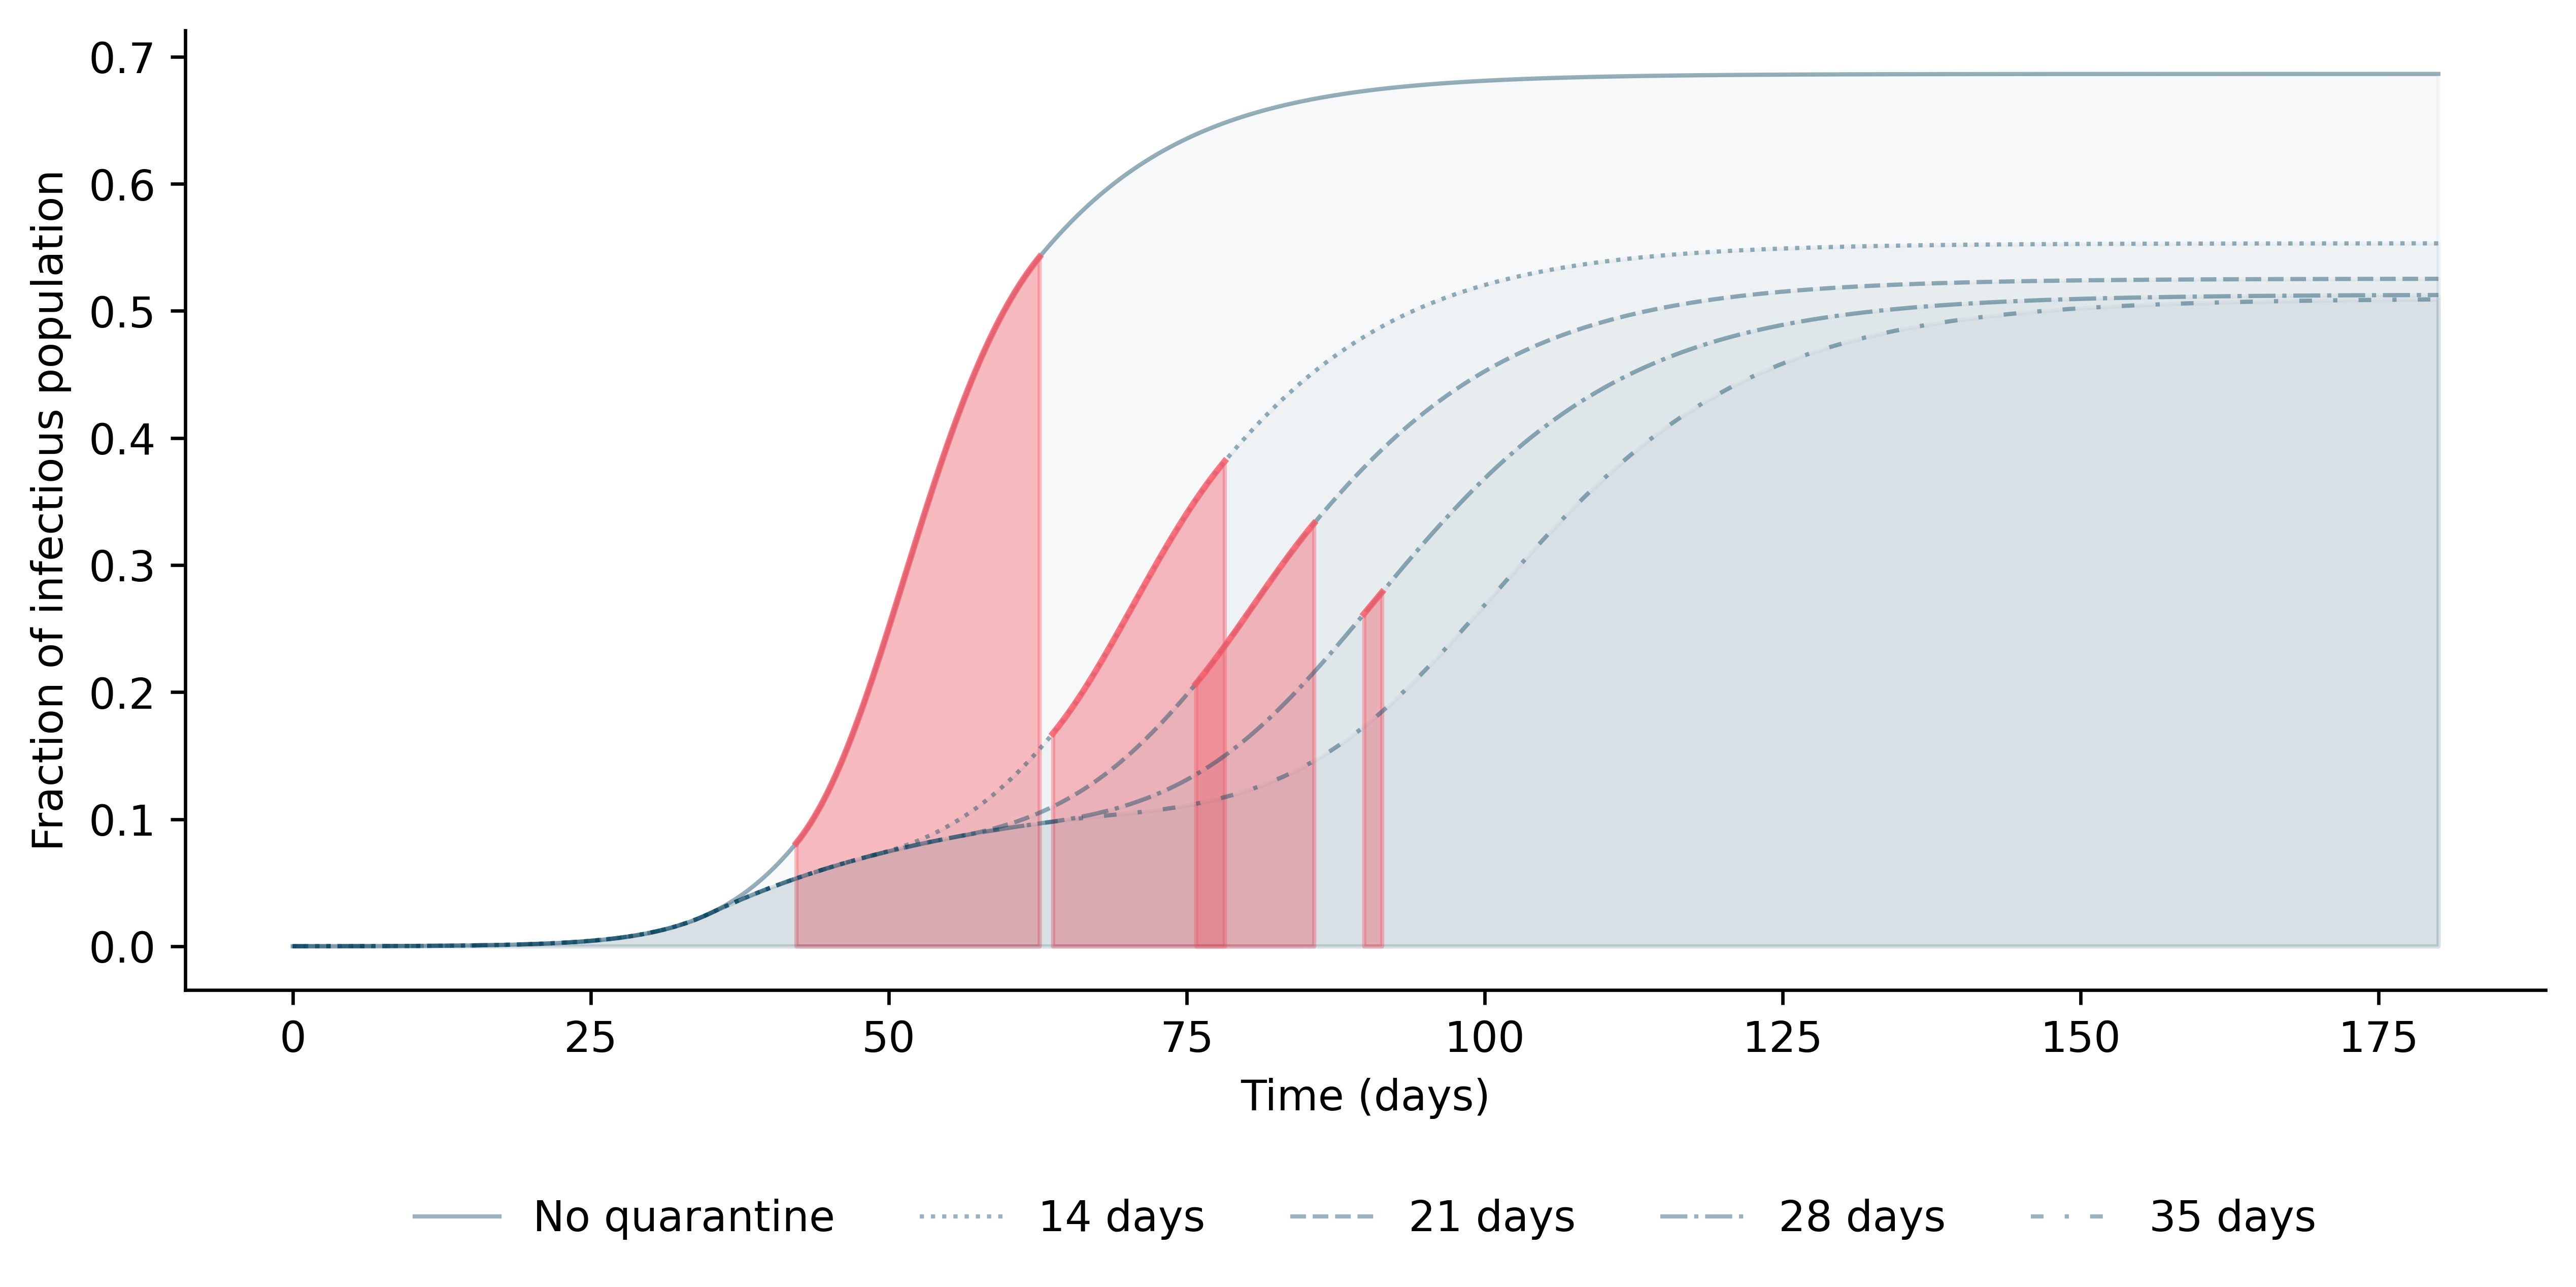

In [9]:
res_q = []

fig = plt.figure(facecolor="w", figsize=(10, 5), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

quarantine_lengths = (0, 14, 21, 28, 35)
line_styles = ("solid", "dotted", "dashed", "dashdot", (0, (3, 5, 1, 5)))

chi = 0.3
c = 0.15

for tau_q in quarantine_lengths:
    res_q.append(solve_ivp(fun=deriv_with_quarantine, t_span=(0, 180), y0=y_0, args=(beta, gamma, chi, tau_q, 35, 0.5, 0.15, c), max_step=0.3))

for idx, result in enumerate(res_q):
    ax.plot(result.t, result.y[2], color=COLORS["D"], alpha=0.4, lw=1, linestyle=line_styles[idx], label=f"{'No quarantine' if quarantine_lengths[idx] == 0 else str(quarantine_lengths[idx]) + ' days'}")
    ax.fill_between(result.t, 0, result.y[2], color=COLORS["D"], alpha=0.03)
    
    result = np.vstack([result.y, result.t])
    excess = np.squeeze(result[:, np.where(result[1] > c)])
    ax.plot(excess[3], excess[2], color=COLORS["I"], alpha=0.8)
    ax.fill_between(excess[3], excess[2], color=COLORS["I"], alpha=0.4)

ax.set_xlabel('Time (days)')
ax.set_ylabel("Fraction of infectious population")
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title='', bbox_to_anchor=(0.5, -0.3), loc="lower center", ncol=5, frameon=False)

fig.subplots_adjust(bottom=0.25)

plt.savefig("death_integral_with_quarantine.pdf")
plt.show()